In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tflearn
import cv2
import random

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
from random import shuffle
from tqdm import tqdm
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from __future__ import division

In [3]:
TEST_DIR = 'test'
TRAIN_DIR = 'train'
IMG_SIZE = 8
LR = 1e-3
MODEL_NAME = 'odr-{}-{}.model'.format(LR, '6conv-basic')

In [4]:
def label_img(img):
    word_label = int(img.split('.')[0])
    one_hot_array = [0 for i in range(10)]
    one_hot_array[word_label] = 1
    return one_hot_array

In [5]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        training_data.append([np.array(img), np.array(label)])
    
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [6]:
def process_test_data():
    testing_data = []
    for num, img in enumerate(tqdm(os.listdir(TEST_DIR))):
        path = os.path.join(TEST_DIR, img)
        img =cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        testing_data.append([np.array(img), num])
    np.save('test_data.npy', testing_data)
    return testing_data

In [7]:
train_data = create_train_data()
# if trained data is already present then
# train_data = np.load('train_data.npy')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 186.80it/s]


In [8]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 10, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

In [9]:
if os.path.exists("{}.meta".format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print ("Model Loaded!")

INFO:tensorflow:Restoring parameters from E:\My Arena\PythonCodes\Deep Learning with Neural Networks\3-Optical_Digit_Recognizer\odr-0.001-6conv-basic.model
Model Loaded!


In [10]:
train = train_data
test = train_data

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE, IMG_SIZE, 1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
test_y = [i[1] for i in test]

In [11]:
model.fit({'input': X}, {'targets': Y}, n_epoch=25, validation_set=({'input': test_x}, {'targets': test_y}),snapshot_step=500, show_metric=True, run_id=MODEL_NAME)
model.save(MODEL_NAME)

Training Step: 139  | total loss: 0.06832 | time: 0.051s
| Adam | epoch: 025 | loss: 0.06832 - acc: 0.9945 -- iter: 64/90
Training Step: 140  | total loss: 0.06172 | time: 1.071s
| Adam | epoch: 025 | loss: 0.06172 - acc: 0.9951 | val_loss: 0.00191 - val_acc: 1.0000 -- iter: 90/90
--
INFO:tensorflow:E:\My Arena\PythonCodes\Deep Learning with Neural Networks\3-Optical_Digit_Recognizer\odr-0.001-6conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 365.61it/s]


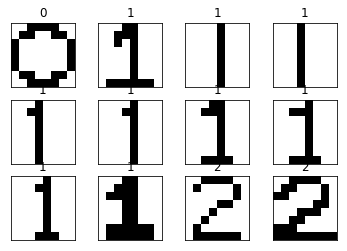

In [12]:
test_data = process_test_data()
#test_data = np.load('test_data.npy')

fig = plt.figure()

initial = random.randrange(0,50,1)

# Now let's plot the images with the predicted tags for 12 pics
for num, data in enumerate(test_data[initial:initial+12]):
    img_num = data[1]
    img_data = data[0]

    y = fig.add_subplot(3, 4 , num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE, 1)
    model_out = model.predict([data])[0]

    str_label = model_out.index(max(model_out))
    
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()


In [13]:
def testing_accuracy():
    correct = 0
    total = len(os.listdir(TRAIN_DIR))
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        name = img.split('.')[0]
        model_out = model.predict(np.array(cv2.imread(os.path.join(TRAIN_DIR,img), cv2.IMREAD_GRAYSCALE)).reshape(-1,IMG_SIZE, IMG_SIZE, 1))[0]
        str_label = model_out.index(max(model_out))
                                  
        #print (name, str_label)
        if str(name) == str(str_label):
            correct += 1
    
    print ("accuracy =", (correct/total)*100)

In [14]:
testing_accuracy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 512.55it/s]


accuracy = 100.0
